### COSC 311 - Project 2<br>
#### Logan Kelsch<br>

In [ ]:
'''1. CLUSTERING FOR WIRELESS INDOOR LOCALIZATION'''

# DATASET:  wifi_localization.txt
# TASKS:    Use k-means clustering

#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin

#grab dataset
data = pd.read_csv('wifi_localization.txt', sep='\t', header=None)

#split into features and targets
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

#prep kmeans              =4 rooms
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
#kmeans.transform(X)

#declare predictions and set center values
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

#NOTE SECTION 1 TASK COMPLETION HERE
#center printouts
for i in range(len(centers)):
    centers[i] = centers[i]*100//1/100
    print(f'Center {i+1}:\t{centers[i]}')

# I have pulled this function from our class notes, as it 
# is the most concise version of cluster matching I could find.
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    # X.shape returns (300, 2), X.shape[0] returns 300
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

#function exection, cluster label-to-target matching
centers, y_pred = find_clusters(X, 4)

#readjust calculated labels for exact valuation
for i in range(len(y_pred)):
    y_pred[i]= ((((y_pred[i] - 4) *-1) %4) +1)

#NOTE SECTION 2 TASK COMPLETION
#total clustering accuracy printout
print(f'\nClustering Accuracy:\t{100*accuracy_score(y_pred, y)}%\n')

#allign y_pred, y_true
ys = (np.column_stack((y_pred,y)))

#seperate all predictions by different ACTUAL rooms
rooms = []
#index of 'rooms' will be room number minus 1
for i in range(1,5):
    rooms.append(ys[ys[:,1] == i])

#NOTE SECTION 3 TASK COMPLETION
#individual room clustering accuracy printout
for i in range(4):
    print(f'Room {i+1} Clustering Accuracy:\t\
          {100*accuracy_score(rooms[i][:,0],rooms[i][:,1])}%')

Center 1:	[-35.44 -55.94 -55.73 -36.7  -67.33 -71.6  -72.57]
Center 2:	[-62.49 -56.32 -60.57 -64.21 -70.28 -82.96 -84.08]
Center 3:	[-60.14 -55.21 -50.65 -61.29 -49.47 -87.03 -87.  ]
Center 4:	[-49.18 -55.16 -53.3  -50.04 -64.05 -80.95 -81.86]

Clustering Accuracy:	95.45%

Room 1 Clustering Accuracy:	99.2%
Room 2 Clustering Accuracy:	85.0%
Room 3 Clustering Accuracy:	98.4%
Room 4 Clustering Accuracy:	99.2%


Dimensions reduced from 64 to 21.

CVT DT model fold accuracies:
   Fold	1:	80.00%
   Fold	2:	85.00%
   Fold	3:	83.89%
   Fold	4:	81.11%
   Fold	5:	81.67%
   Fold	6:	83.33%
   Fold	7:	83.89%
   Fold	8:	79.33%
   Fold	9:	78.21%
   Fold	10:	79.33%

CV (DT) Full accuracy:
	81.30%


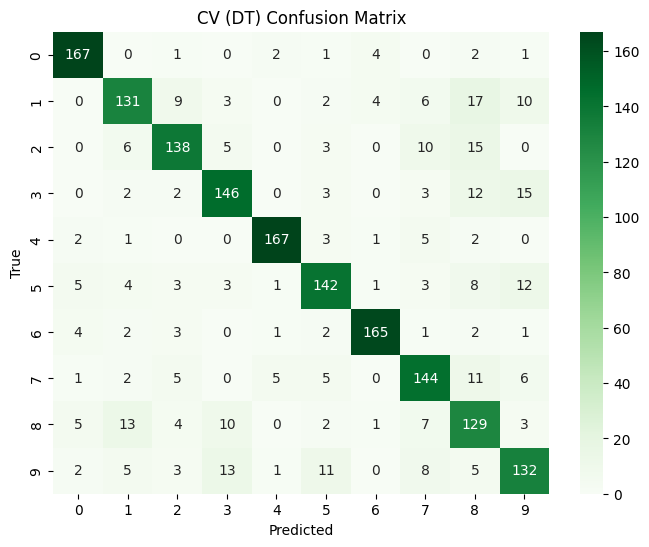

In [62]:
'''2. PCA based hand-written digits classification'''

# DATASET:  UCI ML - from - sklearn and 'COSC311_Module5_4_Kmeans clustering'
# TASKS:    Conduct PCA analysis and CVT 

#import libraries and functions
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns

#load and prep dataset
data = load_digits(as_frame=True)
data = data.frame
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

#pca initiation
pca = PCA()
pca.fit(X)

#PCA primary component and variance calculation
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.9) + 1

#PCA final prep and data transformation
pca = PCA(n_components = n_components)
X_pca = pca.fit_transform(X)

#dimension reduction confirmation printout
print(f'Dimensions reduced from {X.shape[1]} to {X_pca.shape[1]}.\n')

#define classification model and fit
dt = DecisionTreeClassifier(criterion='entropy',max_depth=8)
dt.fit(X_pca,y)

#collect model predictions and cross validation score
scores = cross_val_score(dt, X_pca, y, cv=10)
y_pred = cross_val_predict(dt, X_pca, y, cv=10)

#individual CVT printouts
print('CVT DT model fold accuracies:')
for i in range(len(scores)):
    print(f'   Fold\t{i+1}:\t{100*scores[i]:.2f}%')
print(f'\nCV (DT) Full accuracy:\n\t{100*accuracy_score(y,y_pred):.2f}%')

#confusion matrix creation
cm = confusion_matrix(y, y_pred)

#confusion matrix output
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CV (DT) Confusion Matrix')
plt.show()

MAE:	59750.08
MSE:	6316585663.32
RMSE:	79476.95


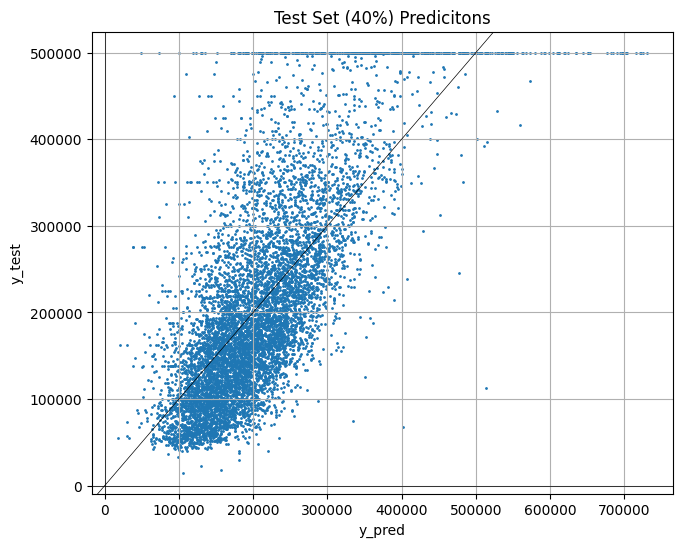

In [ ]:
'''3. Regression model for median house value prediction'''

# DATASET:  housing.csv
# TASKS:    collect most correlated features, train MLR model

#import libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error  #MSE
from sklearn.metrics import root_mean_squared_error #RMSE

#bring data into pddf
data = pd.read_csv('housing.csv')

#detect all datapoints with missing values.
#  used data.info() to see the only feature with missing
#  samples was 'total_bedrooms'
unclean_ndx = data[data['total_bedrooms'].isna()].index
data = data.drop(index=unclean_ndx).reset_index(drop=True)

#drop all irrelevant features for this task
data = data.drop(columns=['ocean_proximity','longitude','latitude','households'])

#generate the correlation of all features to our selected target,
#                                            'median_house_value'
co = data.corr()['median_house_value'].drop('median_house_value')
    #NOTE OUTPUT NOTE OUTPUT
'''
    housing_median_age    0.106432  *** #3
    total_rooms           0.133294  *** #2
    total_bedrooms        0.049686  *** DROP
    population           -0.025300  *** DROP
    median_income         0.688355  *** #1
'''

#drop non-top3 highest correlating features
data = data.drop(columns=['total_bedrooms','population'])

# Separate features and target into X and y
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

#split data into train and testing
X_train, X_test, y_train, y_test = train_test_split\
                            (X, y, test_size= 0.4, random_state=42)

#set, fit and collect predictions of linear regression model
mlr = LinearRegression()
mlr.fit(X_train,y_train)
y_pred = mlr.predict(X_test)

#metrics printout 'MAE', 'MSE', 'RMSE'
print(f'MAE:\t{mean_absolute_error(y_test,y_pred):.2f}')
print(f'MSE:\t{mean_squared_error(y_test,y_pred):.2f}')
print(f'RMSE:\t{root_mean_squared_error(y_test,y_pred):.2f}')

'''####                   ####                      ####
    This code was ripped from some of my personal code.
    The black diagonal line is the y = x line, 
                   or perfect prediction line.
'''####                   ####                      ####
plt.figure(figsize=(7.5, 6))
plt.scatter(y_pred, y_test, s=1)
plt.grid()
plt.axis('tight')
plt.title('Test Set (40%) Predicitons')
plt.xlabel('y_pred')
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()
